In [1]:
import io
import sys
import glob
import joblib
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from AutoML import AutomatedRegression

# - Load data

In [2]:
data_dir = "/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/"
data_type = "4ML_phased_array.nc"
scenarios = glob.glob(f"{data_dir}*{data_type}")

In [3]:
n_test_scenarios = 2
scenarios_train = scenarios[:-n_test_scenarios]
scenarios_test = scenarios[-n_test_scenarios:]

n = 20 # number of azimuth cells to consider from center (e.g. total azimuth cells is 2*n +1)
spacing_slow_time = 2*n # pixels
spacing_ground_range = n # pixels


# --------------Training--------------
X_train = []
y_train = []
for scenario in scenarios_train:
    data = xr.open_dataset(scenario)

    X_data = xr.concat([data.nrcs_scat.isel(slow_time=slice(i-n, 1+i+n)) for i in range(n, len(data.nrcs_scat['slow_time'])-n)], dim='placeholder')
    y_data = xr.concat([data.V_leakage_pulse_rg.isel(slow_time=i) for i in range(n, len(data.V_leakage_pulse_rg['slow_time'])-n)], dim='placeholder')

    # Training
    X_train_spaced = X_data.isel(placeholder=slice(None,None, spacing_slow_time), grg=slice(None,None, spacing_ground_range)).values.reshape(-1, 2*n+1)
    y_train_spaced = y_data.isel(placeholder=slice(None,None, spacing_slow_time), grg=slice(None,None, spacing_ground_range)).values.reshape(-1)

    data_train = pd.DataFrame(np.column_stack((X_train_spaced,y_train_spaced))).dropna()
    X_train.append(data_train.iloc[:,:-1])
    y_train.append(data_train.iloc[:,-1])

X_train = pd.concat(X_train)
y_train = pd.concat(y_train)


# --------------Testing--------------
X_test = []
y_test = []
for scenario in scenarios_test:
    data = xr.open_dataset(scenario)
    
    X_data = xr.concat([data.nrcs_scat.isel(slow_time=slice(i-n, 1+i+n)) for i in range(n, len(data.nrcs_scat['slow_time'])-n)], dim='placeholder')
    y_data = xr.concat([data.V_leakage_pulse_rg.isel(slow_time=i) for i in range(n, len(data.V_leakage_pulse_rg['slow_time'])-n)], dim='placeholder')

    X_test_pre = X_data.values.reshape(-1, 2*n+1)
    y_test_pre = y_data.values.reshape(-1)

    data_test = pd.DataFrame(np.column_stack((X_test_pre,y_test_pre))).dropna()
    X_test.append(data_test.iloc[:,:-1])
    y_test.append(data_test.iloc[:,-1])
                  

In [9]:
def warning_catcher(function, *args):
    with warnings.catch_warnings(record=True) as caught_warnings:
        output_buffer = io.StringIO()
        stdout_save = sys.stdout
        sys.stdout = output_buffer

        try:
            result = function(*args)
        except Exception as e:
            sys.stdout = stdout_save
            print(e)
        
        sys.stdout = stdout_save

    return result


In [32]:
# Instantiate model and overwrite automated Train / Test split

ML = AutomatedRegression(
    X=X_train,           # NOTE these are overwritten 
    y=X_train,           # NOTE these are overwritten 
    n_trial=100,
    models_to_optimize=['bayesianridge', 'lightgbm', 'catboost', 'xgboost'],
    # n_jobs=6,
    n_weak_models=5,
    reload_study=True,
    reload_trial_cap=True,
    write_folder='/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/ML_analyses/Vleak_n_20_5Tr_2Te_v0/',
)

ML.X_test = X_test[0]
ML.X_train = X_train
ML.y_test = y_test[0]
ML.y_train = y_train 


# warning_catcher(ML.apply)

/Users/opodriscoll/Documents/Scripts/DopSCA/src/automl/AutoML/automl.py:236: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_numeric_columns = (~self.X.applymap(np.isreal).any(axis = 0))


In [10]:
model = joblib.load('/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/ML_analyses/Vleak_n_20_5Tr_2Te_v0/stacked_model.joblib')

ML performance, RMSE: 0.776 m/s, median error: -0.094 m/s
Inversion performance, RMSE: 0.335 m/s, median error: -0.026 m/s
ML performance, RMSE: 0.216 m/s, median error: -0.028 m/s
Inversion performance, RMSE: 0.243 m/s, median error: 0.087 m/s


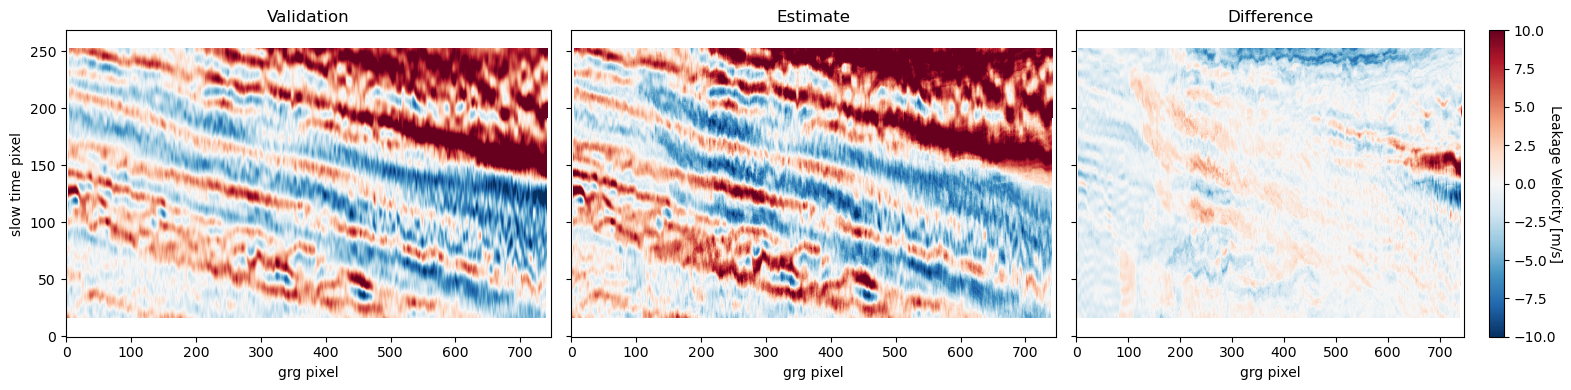

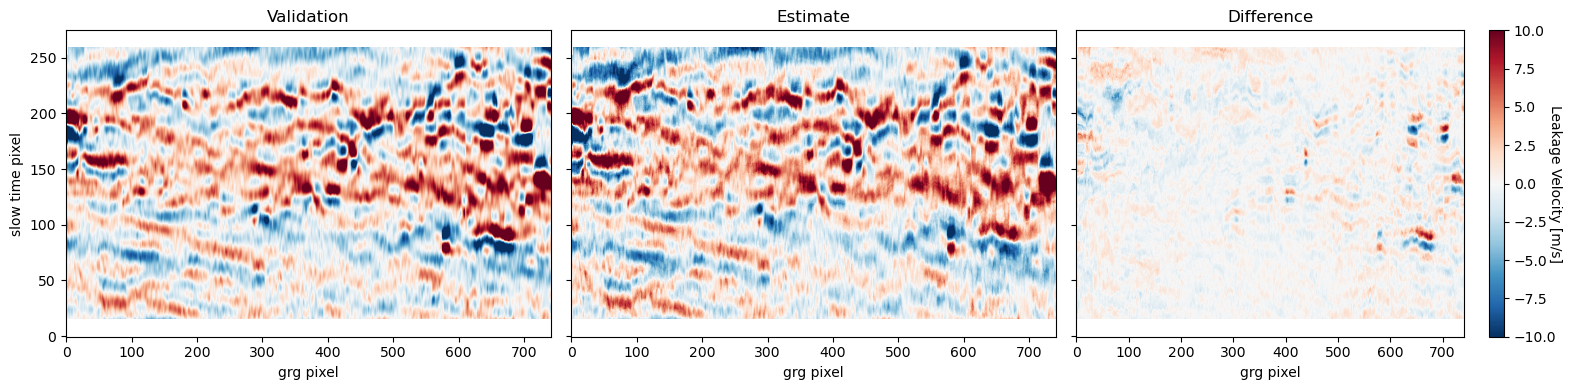

In [18]:
# ------ pixels to average over to obtain 50 x 50 km resolution from 340 x 1700 m pixels
grg_N = 147
slow_time_N = 29


for i, scenario in enumerate(scenarios_test):
    data = xr.open_dataset(scenario)
    
    X_data = xr.concat([data.nrcs_scat.isel(slow_time=slice(i-n, 1+i+n)) for i in range(n, len(data.nrcs_scat['slow_time'])-n)], dim='placeholder')
    y_data = xr.concat([data.V_leakage_pulse_rg.isel(slow_time=i) for i in range(n, len(data.V_leakage_pulse_rg['slow_time'])-n)], dim='placeholder')


    y_pred = warning_catcher(model.predict, X_test[i])
    y_shape = y_data.shape

    theoretical_length = y_data.values.reshape(-1).shape
    A = np.nan * np.arange(theoretical_length[0])
    A[y_test[i].index.values] = y_test[i].values
    A = A.reshape(y_shape)

    B = np.nan * np.arange(theoretical_length[0])
    B[y_test[i].index.values] = y_pred
    B = B.reshape(y_shape)



    slow_time = np.arange(B.shape[0]) + n
    grg = data.grg.values
    da = xr.DataArray(
        data=A-B,
        dims=[ "slow_time", "grg"],
        coords=dict(
            slow_time=(["slow_time"], slow_time),
            grg=(["grg"], grg),
        ),
    )

    inversed = scenario[:-15] + "inverse_" + scenario[-15:]
    data_inversed = xr.open_dataset(inversed)

    coarse_ML = da.coarsen(grg=grg_N, slow_time=slow_time_N, boundary='trim').mean(skipna=False)
    coarse_inverse = (data.V_leakage_pulse_rg - data_inversed.V_leakage_pulse_rg).T.coarsen(grg=grg_N, slow_time=slow_time_N, boundary='trim').mean(skipna=False)

    perf_ML = np.sqrt(np.nanmean(coarse_ML**2)), np.nanmedian(coarse_ML)
    perf_inv = np.sqrt(np.nanmean(coarse_inverse**2)), np.nanmedian(coarse_inverse)

    print(f"ML performance, RMSE: {perf_ML[0]:.3f} m/s, median error: {perf_ML[1]:.3f} m/s")
    print(f"Inversion performance, RMSE: {perf_inv[0]:.3f} m/s, median error: {perf_inv[1]:.3f} m/s")




    fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True, sharey=True)

    vmin = -10;
    vmax = 10
    im0 = axes[0].imshow(A, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu_r')
    im1 = axes[1].imshow(B.reshape(y_shape), origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu_r')
    im2 = axes[2].imshow(A - B, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu_r')
    [ax.set_xlabel('grg pixel') for ax in axes]
    axes[0].set_ylabel('slow time pixel')
    axes[0].set_title('Validation')
    axes[1].set_title('Estimate')
    axes[2].set_title('Difference')
    cbar = plt.colorbar(im0, ax=axes[2])
    cbar.ax.set_ylabel('Leakage Velocity [m/s]', rotation=270)
    fig.tight_layout()